In [1]:
#import statements
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
from matplotlib import colorbar
import cartopy
import cartopy.util as util
import cartopy.crs as ccrs
import cartopy.feature as cfeature  # features such as the ocean, coastlines rivers, etc

mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [2]:
def pop_add_cyclic(ds):
    
    nj = ds.TLAT.shape[0] # size of POP grid
    ni = ds.TLONG.shape[1]

    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = ds.TLONG.data
    tlat = ds.TLAT.data
#    print('Here')    
    tlon = np.where(np.greater_equal(tlon, min(tlon[:,0])), tlon-360., tlon) #make monotoncially increasing
    lon  = np.concatenate((tlon, tlon + 360.), 1) # concatenate to make larger array
    lon = lon[:, xL:xR] #restrict to middle rane
#    print('Here')   
    if ni == 320: # this is the x1 POP grid
        print('\n')
       # lon[367:-3, 0] = lon[367:-3, 0] + 360.        #####TUPLE PROBLEM IS HERE
      #  print('Here')
    lon = lon - 360.
    
    lon = np.hstack((lon, lon[:, 0:1] + 360.)) # add in cyclic point

    if ni == 320:
        print('\n')
        #lon[367:, -1] = lon[367:, -1] - 360.  #####TUPLE PROBLEM IS HERE
        
    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    
   # lon[:, 0] = lon[:, 0] - 1e-8    ######TUPLE PROBLEM IS HERE
   
    #-- periodicity
    lat = np.concatenate((tlat, tlat), 1)
    lat = lat[:, xL:xR]
    lat = np.hstack((lat, lat[:,0:1]))

    TLAT = xr.DataArray(lat, dims=('nlat', 'nlon'))
    TLONG = xr.DataArray(lon, dims=('nlat', 'nlon'))
    
    dso = xr.Dataset({'TLAT': TLAT, 'TLONG': TLONG})
    
    # copy vars
    varlist = [v for v in ds.data_vars if v not in ['TLAT', 'TLONG']]
    for v in varlist:
        v_dims = ds[v].dims
        if not ('nlat' in v_dims and 'nlon' in v_dims):
            dso[v] = ds[v]
        else:
            # determine and sort other dimensions
            other_dims = set(v_dims) - {'nlat', 'nlon'}
            other_dims = tuple([d for d in v_dims if d in other_dims])
            lon_dim = ds[v].dims.index('nlon')
            field = ds[v].data
            field = np.concatenate((field, field), lon_dim)
            field = field[..., :, xL:xR]
            field = np.concatenate((field, field[..., :, 0:1]), lon_dim)       
            dso[v] = xr.DataArray(field, dims=other_dims+('nlat', 'nlon'), 
                                  attrs=ds[v].attrs)


    # copy coords
    for v, da in ds.coords.items():
        if not ('nlat' in da.dims and 'nlon' in da.dims):
            dso = dso.assign_coords(**{v: da})
                
            
    return dso

In [3]:
#open the data
path = '/glade/u/home/chsharri/Work/NW/'
data = xr.open_dataset(path+'nw_ur_150_07.pop.h.TEMP.nc')

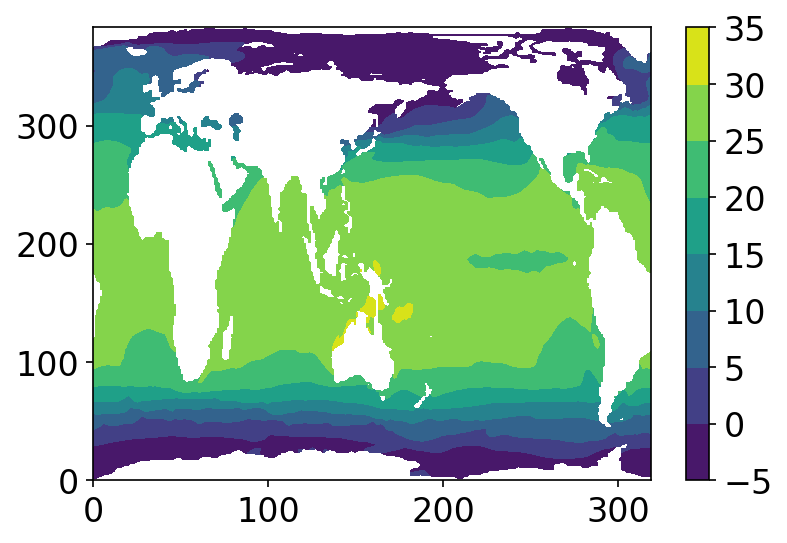

In [25]:
#a quick glance at the data
p = plt.contourf(data['TEMP'][0,0,:,:])
plt.colorbar(p)

In [20]:
data

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 320, time: 360, z_t: 60)
Coordinates:
  * time        (time) object 0005-02-01 00:00:00 ... 0035-01-01 00:00:00
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    TLONG       (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    TLAT        (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound  (time, d2) object ...
    TEMP        (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan
Attributes:
    title:                     nw_ur_150_07
    history:                   Fri Mar 20 14:28:29 2020: ncrcat -v TEMP /pl/a...
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    contents:                  Diagnostic and Prognostic Variables
    source:                    CCSM POP2, the CCSM Ocean Component
    revision:                  $Id: tavg.F90 56176 2013-12-20 18:35:46Z mlevy...
    calendar:                  All years have exactly  365 days.
    start_time:                This dataset was created on 2018-06-25 at 01:1...
    cell_methods:              cell_methods = time: mean ==> the variable val...
    nsteps_total:              750
    tavg_sum:                  2592000.0
    tavg_sum_qflux:            2592000.0
    NCO:                       "4.6.0"
    nco_openmp_thread_number:  1

In [21]:
x = data['TLONG']
y = data['TLAT']
plot = np.mean(data.TEMP,axis=0) #taking the mean through time

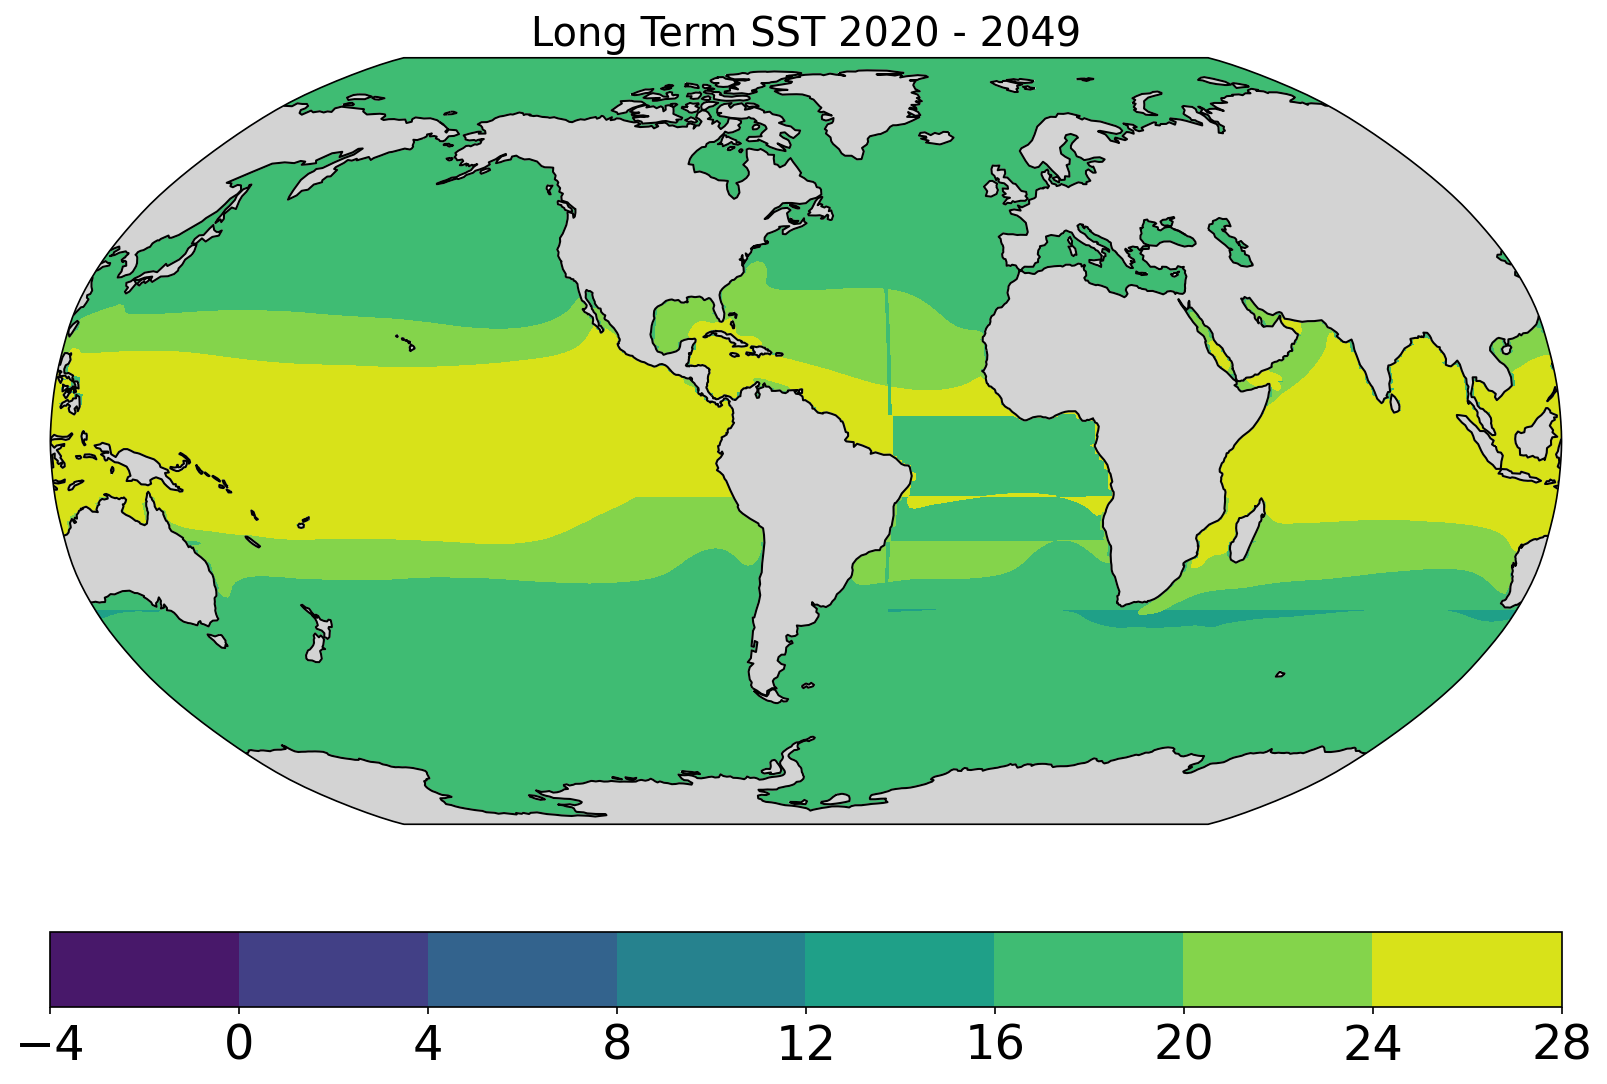

In [22]:


levels = np.arange(-30,32.5,2.5) #define the levels we are going to use

fig,ax= plt.subplots(figsize =(13,19),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=-60))) # defining a figure
title = 'Long Term SST 2020 - 2049'
plt.title(title)
ax.add_feature(cfeature.LAND, color = 'lightgray',zorder = 1) #adding land
ax.add_feature(cfeature.COASTLINE,zorder = 1) #adding a coastline
ax.set_global()  

#plot the data
p = ax.contourf(x, y,
                plot[0,:,:], #plot the surface
                transform=ccrs.PlateCarree())

cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, fraction=0.05,ax=ax) # add a colorbar
cbar.ax.tick_params(labelsize=23) #change the size of the ticks on the colorbar
    
    
#save the picture
saveLocation = '/glade/u/home/vgarza/'
#fig.savefig(saveLocation+title, bbox_inches='tight', quality = 95, dpi = 500)

plt.show() 
plt.close()

## Data looks off, so fix that by adding pop_add_cyclic

In [13]:
data_cyclic = pop_add_cyclic(data) # Remove seam

In [19]:
data_cyclic

<xarray.Dataset>
Dimensions:     (d2: 2, nlat: 384, nlon: 321, time: 360, z_t: 60)
Coordinates:
  * time        (time) object 0005-02-01 00:00:00 ... 0035-01-01 00:00:00
  * z_t         (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    TLAT        (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 80.31 80.31 80.31
    TLONG       (nlat, nlon) float64 -220.6 -219.4 -218.3 ... -39.57 320.1
    time_bound  (time, d2) object ...
    TEMP        (time, z_t, nlat, nlon) float32 nan nan nan nan ... nan nan nan

In [14]:
x = data_cyclic['TLONG']
y = data_cyclic['TLAT']
plot = np.mean(data_cyclic.TEMP,axis=0)

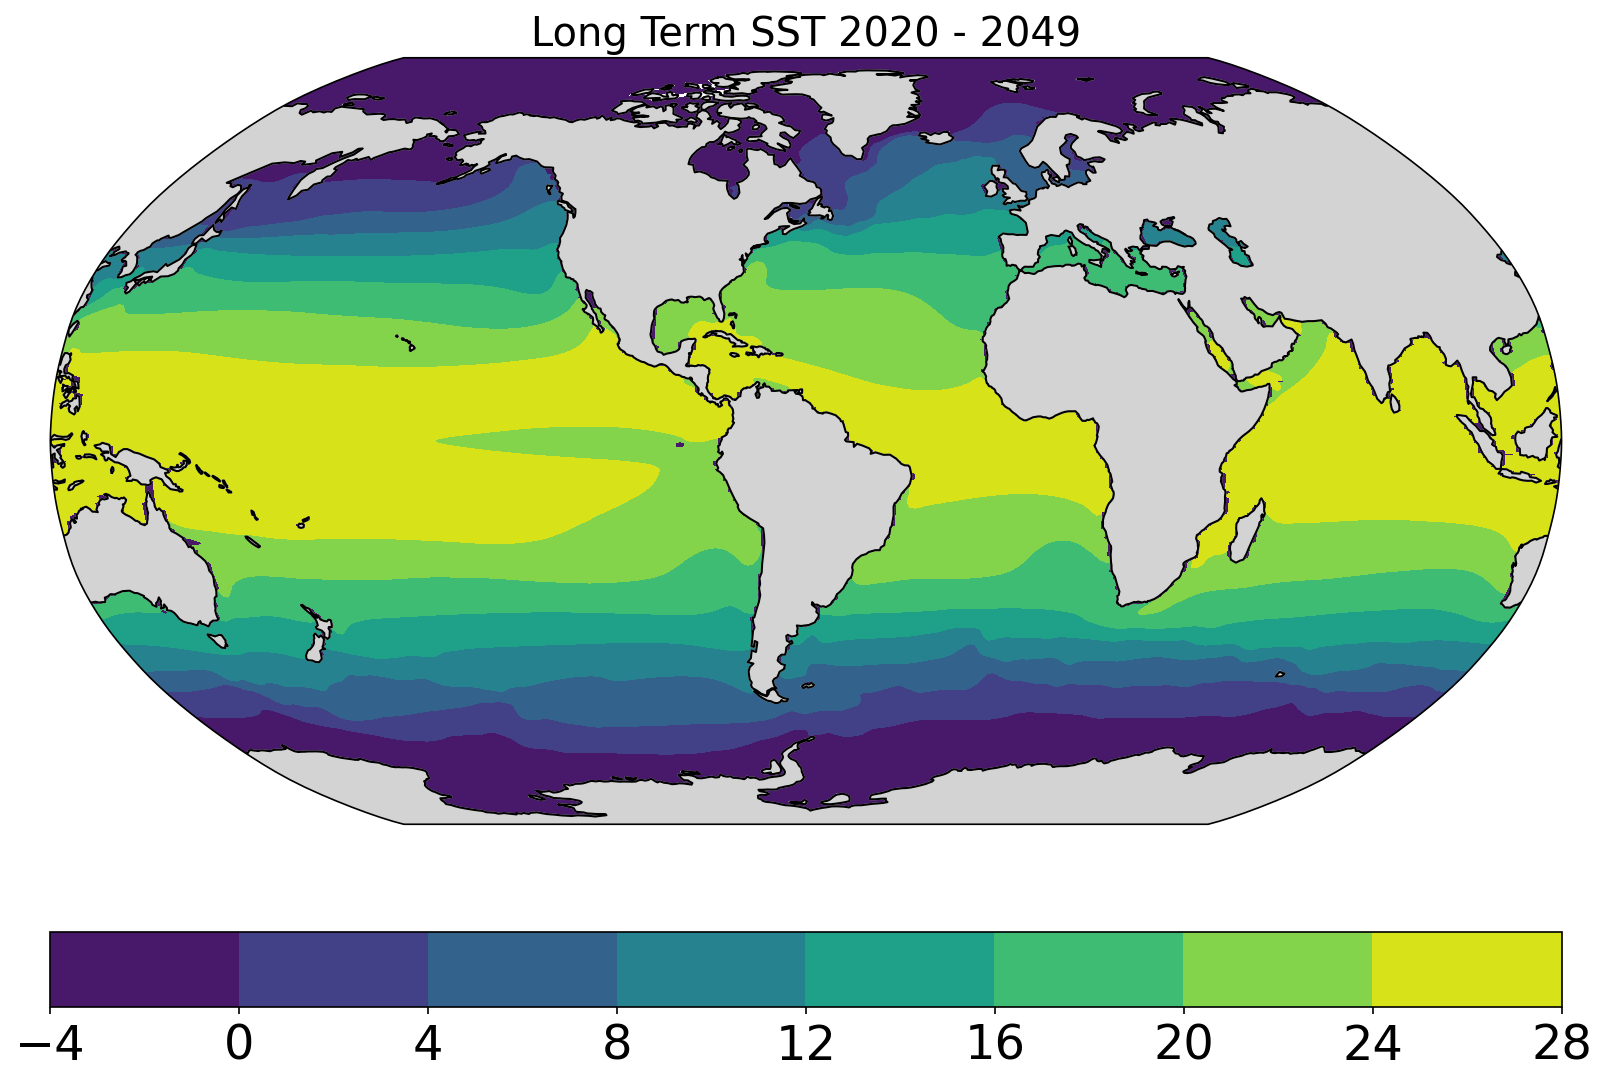

In [16]:
fig,ax= plt.subplots(figsize =(13,19),subplot_kw=dict(projection=ccrs.Robinson(central_longitude=-60))) # defining a figure

plt.title('Long Term SST 2020 - 2049')
ax.add_feature(cfeature.LAND, color = 'lightgray',zorder = 1) #adding land
ax.add_feature(cfeature.COASTLINE) #adding a coastline
ax.set_global()  

#plot the data
p = ax.contourf(x, y,
                plot[0,:,:],
                 transform=ccrs.PlateCarree())
cbar = plt.colorbar(p, orientation='horizontal', pad=0.05, fraction=0.05,ax=ax) 
cbar.ax.tick_params(labelsize=23)
    
    
#save the picture
saveLocation = '/glade/u/home/vgarza/'

#fig.savefig(saveLocation+caseName.translate(mytable)+ ' Diagnostic', bbox_inches='tight', quality = 95, dpi = 500)

plt.show() 
plt.close()